In [1]:
import os
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import numpy as np

load_dotenv()

%matplotlib notebook
# Test out RDS connection.
conn = psycopg2.connect(host=os.getenv("POSTGRES_HOST"),
                        dbname=os.getenv("POSTGRES_NAME"),
                        user=os.getenv("POSTGRES_USER"),
                        port=os.getenv("POSTGRES_PORT"),
                        password=os.getenv("POSTGRES_PASSWORD"))

curs = conn.cursor()
curs.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema='public'""")
for _ in curs.fetchall():
    print(_[0])

geography_columns
geometry_columns
spatial_ref_sys
raster_columns
raster_overviews
django_admin_log
django_session
tl_2018_41_bg
tl_2018_41_tabblock10
tl_2018_41_tract
django_migrations
django_content_type
auth_permission
auth_group
auth_group_permissions
auth_user_groups
auth_user_user_permissions
auth_user
tm_boundary
tm_parkride
tm_rail_lines
tm_rail_stops
tm_route_stops
tm_routes
tm_stops
tm_tran_cen
bus_all_stops
bus_all_stops_y2017m09
bus_all_stops_y2017m10
bus_all_stops_y2017m11
bus_all_stops_y2018m09
bus_all_stops_y2018m10
bus_all_stops_y2018m11
bus_passenger_stops_y2017m10
bus_passenger_stops
bus_passenger_stops_y2017m09
bus_passenger_stops_y2017m11
bus_passenger_stops_y2018m09
disturbance_stops
bus_passenger_stops_y2018m10
bus_passenger_stops_y2018m11
bus_routes
bus_service_keys
bus_trips
disturbance_stops_y2017m09
disturbance_stops_y2017m10
disturbance_stops_y2017m11
rail_passenger_stops
disturbance_stops_y2018m09
disturbance_stops_y2018m10
disturbance_stops_y2018m11
rail_pa

The goal is to calculate (or really, set up a databse to calculate) stop to stop durations for all bus routes. The idea is that this average stop to stop time for various filters (time of day, day of week).

To do so, The idea here is to take every trip from `bus_trips`, grab the corresponding stops from that trip, then see how they can be aggregated.

The `stop_types` to make note of here are 0 and 5 for 'stop' and 4 and 6 for 'drive thru'

Given that our database could reflect some changes in stops, I plan to look at the data we do have rather than the prescribed routes.

For now, let's start with something I know well, the 35!

In [2]:
# These are the columns we have access to.
curs = conn.cursor()
curs.execute("""SELECT column_name FROM information_schema.columns WHERE table_name = 'bus_all_stops'""")
cols = [c[0] for c in curs.fetchall()]
for c in cols:
    print(c)

vehicle_id
opd_date
day_of_week
year
month
day
act_arr_time
act_dep_time
nom_arr_time
nom_dep_time
event_no_trip
line_id
pattern_direction
meters
stop_id
stop_pos
distance_to_next
distance_to_trip
doors_opening
stop_type
door_open_time
gps_longitude
gps_latitude
geom_point_4326
id


In [3]:
# These are the columns we have access to.
curs = conn.cursor()
curs.execute("""SELECT column_name FROM information_schema.columns WHERE table_name = 'bus_trips'""")
cols = [c[0] for c in curs.fetchall()]
for c in cols:
    print(c)

vehicle_id
opd_date
act_dep_time
act_end_time
nom_dep_time
nom_end_time
event_no_trip
meters
line_id
pattern_direction


In [4]:
query = """SELECT * FROM public.bus_trips WHERE line_id = 35 ORDER BY event_no_trip"""

curs.execute(query)
trips = [{l:v for l,v in zip(cols, row)} for row in curs.fetchall()]
print(len(trips))

14560


cool, 14,560 trips

In [5]:
event_no_trips = ','.join([str(trip['event_no_trip']) for trip in trips])
query = (f"SELECT event_no_trip, pattern_direction, line_id, stop_id, stop_type, act_arr_time, act_dep_time "
         f"FROM bus_all_stops "
         f"WHERE event_no_trip in ({event_no_trips}) " 
         f"AND stop_type in (0, 5, 4, 6) ORDER BY event_no_trip, act_arr_time")

df = pd.read_sql(query, conn)
df['prev_stop_act_arr_time'] = df['act_arr_time'].shift(1)
df['cur_stop_act_arr_time'] = df['act_arr_time']
df['elapsed_time'] = (df['cur_stop_act_arr_time'] - df['prev_stop_act_arr_time'])
df['elapsed_time_seconds'] = df['elapsed_time'].apply(lambda x: x.seconds).astype('Int64')
df['prev_stop_id'] = df['stop_id'].shift(1).astype('Int64')
df['cur_stop_id'] = df['stop_id']

df.loc[df[df['event_no_trip'] != df['event_no_trip'].shift(1)].index,
       ['elapsed_time', 'prev_stop_id', 'prev_stop_act_arr_time', 'elapsed_time_seconds']] = np.nan

df

,event_no_trip,pattern_direction,line_id,stop_id,stop_type,act_arr_time,act_dep_time,prev_stop_act_arr_time,cur_stop_act_arr_time,elapsed_time,elapsed_time_seconds,prev_stop_id,cur_stop_id
0,868692515,I,35,8762,0,2017-09-01 12:25:29+00:00,2017-09-01 12:25:29+00:00,NaT,2017-09-01 12:25:29+00:00,NaT,NaN,NaN,8762
1,868692515,I,35,6320,0,2017-09-01 12:29:04+00:00,2017-09-01 12:29:19+00:00,2017-09-01 12:25:29+00:00,2017-09-01 12:29:04+00:00,00:03:35,215,8762,6320
2,868692515,I,35,6306,0,2017-09-01 12:29:47+00:00,2017-09-01 12:30:07+00:00,2017-09-01 12:29:04+00:00,2017-09-01 12:29:47+00:00,00:00:43,43,6320,6306
3,868692515,I,35,13603,4,2017-09-01 12:30:26+00:00,2017-09-01 12:30:26+00:00,2017-09-01 12:29:47+00:00,2017-09-01 12:30:26+00:00,00:00:39,39,6306,13603
4,868692515,I,35,6321,4,2017-09-01 12:30:41+00:00,2017-09-01 12:30:41+00:00,2017-09-01 12:30:26+00:00,2017-09-01 12:30:41+00:00,00:00:15,15,13603,6321
5,868692515,I,35,6312,4,2017-09-01 12:31:15+00:00,2017-09-01 12:31:15+00:00,2017-09-01 12:30:41+00:00,2017-09-01 12:31:15+00:00,00:00:34,34,6321,6312
6,868692515,I,35,6303,4,2017-09-01 12:31:44+00:00,2017-09-01 12:31:44+00:00,2017-09-01 12:31:15+00:00,2017-09-01 12:31:44+00:00,00:00:29,29,6312,6303
7,868692515,I,35,6323,4,2017-09-01 12:31:57+00:00,2017-09-01 12:31:57+00:00,2017-09-01 12:31:44+00:00,2017-09-01 12:31:57+00:00,00:00:13,13,6303,6323
8,868692515,I,35,6344,4,2017-09-01 12:32:13+00:00,2017-09-01 12:32:13+00:00,2017-09-01 12:31:57+00:00,2017-09-01 12:32:13+00:00,00:00:16,16,6323,6344
9,868692515,I,35,6325,4,2017-09-01 12:32:21+00:00,2017-09-01 12:32:21+00:00,2017-09-01 12:32:13+00:00,2017-09-01 12:32:21+00:00,00:00:08,8,6344,6325


In [8]:
B = df[(df['prev_stop_id'] == 2213) & (df['cur_stop_id'] == 2186)]
B

,event_no_trip,pattern_direction,line_id,stop_id,stop_type,act_arr_time,act_dep_time,prev_stop_act_arr_time,cur_stop_act_arr_time,elapsed_time,elapsed_time_seconds,prev_stop_id,cur_stop_id
112,868692611,O,35,2186,0,2017-09-01 14:02:55+00:00,2017-09-01 14:03:05+00:00,2017-09-01 14:01:59+00:00,2017-09-01 14:02:55+00:00,00:00:56,56,2213,2186
294,868692819,O,35,2186,4,2017-09-01 17:28:57+00:00,2017-09-01 17:28:57+00:00,2017-09-01 17:28:26+00:00,2017-09-01 17:28:57+00:00,00:00:31,31,2213,2186
477,868693042,O,35,2186,0,2017-09-01 20:53:06+00:00,2017-09-01 20:53:21+00:00,2017-09-01 20:52:36+00:00,2017-09-01 20:53:06+00:00,00:00:30,30,2213,2186
656,868693280,O,35,2186,0,2017-09-02 00:41:30+00:00,2017-09-02 00:41:42+00:00,2017-09-02 00:40:15+00:00,2017-09-02 00:41:30+00:00,00:01:15,75,2213,2186
938,868989676,O,35,2186,4,2017-09-01 23:37:45+00:00,2017-09-01 23:37:45+00:00,2017-09-01 23:37:13+00:00,2017-09-01 23:37:45+00:00,00:00:32,32,2213,2186
1023,868990225,O,35,2186,4,2017-09-01 21:30:18+00:00,2017-09-01 21:30:18+00:00,2017-09-01 21:29:57+00:00,2017-09-01 21:30:18+00:00,00:00:21,21,2213,2186
1204,869812513,O,35,2186,0,2017-09-01 12:46:37+00:00,2017-09-01 12:46:51+00:00,2017-09-01 12:46:10+00:00,2017-09-01 12:46:37+00:00,00:00:27,27,2213,2186
1386,869812734,O,35,2186,4,2017-09-01 16:20:18+00:00,2017-09-01 16:20:18+00:00,2017-09-01 16:19:31+00:00,2017-09-01 16:20:18+00:00,00:00:47,47,2213,2186
1569,869812956,O,35,2186,0,2017-09-01 19:47:10+00:00,2017-09-01 19:47:27+00:00,2017-09-01 19:46:02+00:00,2017-09-01 19:47:10+00:00,00:01:08,68,2213,2186
1751,869813198,O,35,2186,4,2017-09-01 23:27:22+00:00,2017-09-01 23:27:22+00:00,2017-09-01 23:26:36+00:00,2017-09-01 23:27:22+00:00,00:00:46,46,2213,2186


/Users/jbeyer/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


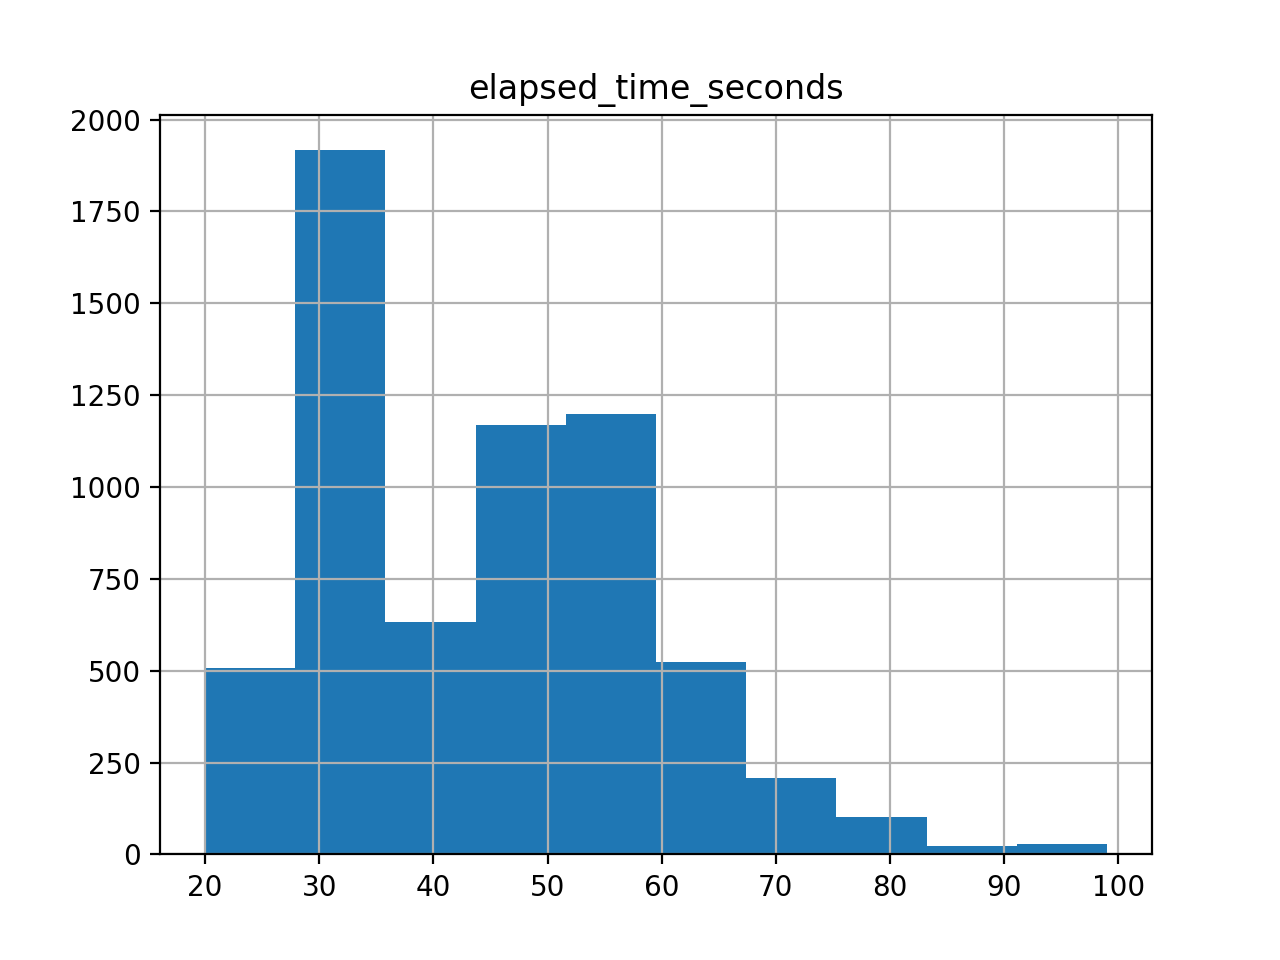

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12abfcf98>]],
      dtype=object)

In [31]:
B['elapsed_time_seconds'] = B['elapsed_time_seconds'].astype('int')
B[B['elapsed_time_seconds'] < 100].hist('elapsed_time_seconds', bins=10)

In [56]:
query = (f"SELECT event_no_trip, pattern_direction, line_id, stop_id, stop_type, act_arr_time "
         f"FROM bus_all_stops "
         f"WHERE stop_type in (0, 5, 4, 6) ORDER BY event_no_trip, act_arr_time")

df = pd.read_sql(query, conn)
df['prev_stop_act_arr_time'] = df['act_arr_time'].shift(1)
df['elapsed_time_seconds'] = (df['act_arr_time'] - df['prev_stop_act_arr_time']).apply(lambda x: x.seconds)
df['prev_stop_id'] = df['stop_id'].shift(1)
df.loc[df[df['event_no_trip'] != df['event_no_trip'].shift(1)].index,
       ['prev_stop_id', 'prev_stop_act_arr_time', 'elapsed_time_seconds']] = np.nan
df.head()

,event_no_trip,pattern_direction,line_id,stop_id,stop_type,act_arr_time,prev_stop_act_arr_time,elapsed_time_seconds,prev_stop_id
0,868641450,O,72,12922,0,2017-09-01 13:24:52+00:00,NaT,NaN,NaN
1,868641450,O,72,7941,0,2017-09-01 13:26:39+00:00,2017-09-01 13:24:52+00:00,107.0,12922.0
2,868641450,O,72,7920,0,2017-09-01 13:27:22+00:00,2017-09-01 13:26:39+00:00,43.0,7941.0
3,868641450,O,72,7918,4,2017-09-01 13:28:01+00:00,2017-09-01 13:27:22+00:00,39.0,7920.0
4,868641450,O,72,7968,4,2017-09-01 13:28:15+00:00,2017-09-01 13:28:01+00:00,14.0,7918.0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54694746 entries, 0 to 54694745
Data columns (total 9 columns):
event_no_trip             int64
pattern_direction         object
line_id                   int64
stop_id                   int64
stop_type                 int64
act_arr_time              datetime64[ns, UTC]
prev_stop_act_arr_time    datetime64[ns, UTC]
elapsed_time_seconds      float64
prev_stop_id              float64
dtypes: datetime64[ns, UTC](2), float64(2), int64(4), object(1)
memory usage: 3.7+ GB


In [59]:
df.describe()

,event_no_trip,line_id,stop_id,stop_type,elapsed_time_seconds,prev_stop_id
count,5.469475e+07,5.469475e+07,5.469475e+07,5.469475e+07,5.384700e+07,5.384700e+07
mean,1.037698e+09,4.176512e+01,5.676966e+03,2.314283e+00,5.394867e+01,5.642415e+03
std,1.347547e+08,3.051176e+01,3.735533e+03,1.975194e+00,6.364772e+01,3.717511e+03
min,8.686414e+08,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,9.030676e+08,1.500000e+01,2.432000e+03,0.000000e+00,2.300000e+01,2.422000e+03
50%,1.136198e+09,3.500000e+01,5.491000e+03,4.000000e+00,3.900000e+01,5.471000e+03
75%,1.169716e+09,7.200000e+01,8.005000e+03,4.000000e+00,6.500000e+01,7.986000e+03
max,1.207567e+09,2.910000e+02,1.401900e+04,6.000000e+00,1.559200e+04,1.401900e+04


In [60]:
df.dropna(inplace=True)
data_types = {
    'line_id': 'uint16',
    'event_no_trip': 'uint32',
    'stop_id': 'uint16',
    'stop_type': 'uint8',
    'elapsed_time_seconds': 'uint16',
    'prev_stop_id': 'uint16',
}

for col, dtype in data_types.items():
    df[col] = df[col].astype(dtype)

df = df[['event_no_trip', 'pattern_direction', 'line_id', 'stop_type', 'stop_id', 'act_arr_time',
         'prev_stop_id', 'prev_stop_act_arr_time', 'elapsed_time_seconds']]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53847000 entries, 1 to 54694745
Data columns (total 9 columns):
event_no_trip             uint32
pattern_direction         object
line_id                   uint16
stop_type                 uint8
stop_id                   uint16
act_arr_time              datetime64[ns, UTC]
prev_stop_id              uint16
prev_stop_act_arr_time    datetime64[ns, UTC]
elapsed_time_seconds      uint16
dtypes: datetime64[ns, UTC](2), object(1), uint16(4), uint32(1), uint8(1)
memory usage: 2.3+ GB


In [63]:
df.describe()

,event_no_trip,line_id,stop_type,stop_id,prev_stop_id,elapsed_time_seconds
count,5.384700e+07,5.384700e+07,5.384700e+07,5.384700e+07,5.384700e+07,5.384700e+07
mean,1.037649e+09,4.169628e+01,2.344551e+00,5.640640e+03,5.642415e+03,5.394867e+01
std,1.347554e+08,3.044279e+01,1.970140e+00,3.717116e+03,3.717511e+03,6.364772e+01
min,8.686414e+08,1.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00
25%,9.030604e+08,1.500000e+01,0.000000e+00,2.421000e+03,2.422000e+03,2.300000e+01
50%,1.136185e+09,3.500000e+01,4.000000e+00,5.469000e+03,5.471000e+03,3.900000e+01
75%,1.169710e+09,7.200000e+01,4.000000e+00,7.984000e+03,7.986000e+03,6.500000e+01
max,1.207567e+09,2.910000e+02,6.000000e+00,1.401900e+04,1.401900e+04,1.559200e+04


In [64]:
df.to_csv('/users/jbeyer/desktop/stop_to_stop.csv', index=False, chunksize=10000)

In [65]:
df.shape

(53847000, 9)

<IPython.core.display.Javascript object>


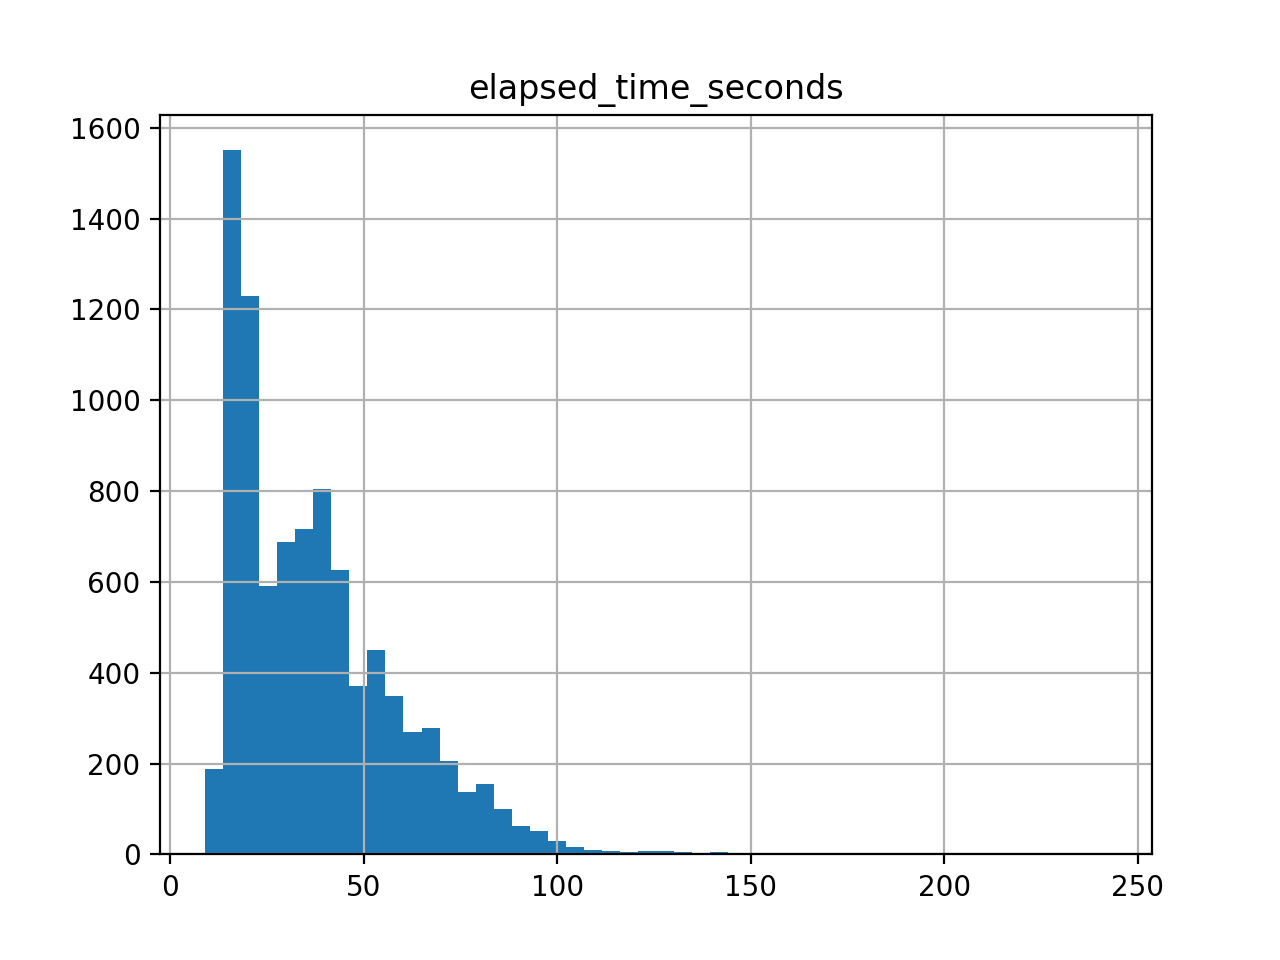

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14335a588>]],
      dtype=object)

In [73]:
df[(df['stop_id'] == 8015) & (df['prev_stop_id'] == 7968)].hist('elapsed_time_seconds', bins=50)

In [24]:
df.to_parquet('/users/jbeyer/desktop/stop_to_stop.parquet.gzip', compression='gzip')

In [3]:
# These are the columns we have access to.
curs = conn.cursor()
curs.execute("""SELECT column_name FROM information_schema.columns WHERE table_name = 'tm_route_stops'""")
cols = [c[0] for c in curs.fetchall()]
for c in cols:
    print(c)

ogc_fid
rte
dir
rte_desc
dir_desc
type
stop_seq
stop_id
stop_name
jurisdic
zipcode
frequent
wkb_geometry
ogc_fid
rte
dir
rte_desc
dir_desc
type
stop_seq
stop_id
stop_name
jurisdic
zipcode
frequent
wkb_geometry


In [25]:
query = """SELECT rte, dir, stop_seq, stop_id, stop_name FROM public.tm_route_stops ORDER BY rte, dir, stop_seq"""

df = pd.read_sql(query, conn)
df.to_parquet('../data/interim/TOAD/route_stops.parquet.gzip', compression='gzip')

In [26]:
df[(df['rte'] == 35) & (df['dir'] == 0)]

,rte,dir,stop_seq,stop_id,stop_name
3500,35,0,75,9635,N Portsmouth & Willamette
3501,35,0,150,4502,N Portsmouth & Yale
3502,35,0,200,4497,N Portsmouth & Princeton
3503,35,0,250,4492,N Portsmouth & Depauw
3504,35,0,300,4495,N Portsmouth & Lombard St
3505,35,0,350,4501,N Portsmouth & Willis
3506,35,0,400,6380,N Willis & Hodge
3507,35,0,450,6376,N Willis & Druid
3508,35,0,500,6381,N Willis & Newman
3509,35,0,550,6392,N Willis & Woolsey


In [21]:
pwd

'/Users/jbeyer/ho_repos/2019-transportation-data-science/notebooks'